In [1]:
# if packages are missing, please uncomment the lines below and run cell
# %pip install -r ./requirements.txt

# 1.26.4 is needed for something else 
# The following depend on your gpu and ur cuda-enabledness. 
# %pip install torch==2.3.0+cpu
# %pip install torchvision==0.18.0+cpu
# %pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu121/torch2.3/index.html

In [2]:
# python standard library
import contextlib
import io
import itertools
import json
import os
import threading
import warnings
from abc import ABC, abstractmethod
from collections.abc import Sequence
from enum import Enum, auto
from typing import Any

# not python standard library
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.optim as optim
from baseline_model import get_flowers_dataloaders, set_seed, train_epoch, validate
from mmcv.ops import DeformConv2d
from safetensors.torch import load_file as safe_load
from timm.models.resnet import BasicBlock, Bottleneck, ResNet
from timm.models.vision_transformer import VisionTransformer
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore", message=".*_MultiProcessingDataLoaderIter.*")


Dataset found at: ../data\flowers-102
Loading Flowers102 dataset...


c:\Users\kyeyo\OneDrive\Desktop\SC4001\Group Assignment\mmcv_env\Lib\site-packages\torch\utils\cpp_extension.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]
c:\Users\kyeyo\OneDrive\Desktop\SC4001\Group Assignment\mmcv_env\Lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
# === Model Setup ===

# Default list for full experiments
model_names_default = [
	"resnet18",
	"resnet34",
	"resnet50",
	"resnet101",
	"resnet152",
	"vit_base_patch32_224",
	"vit_base_patch16_224",
]

# Smaller list for quick debugging
model_names_debug = [
	"resnet18",
	"resnet34",
	"vit_base_patch32_224",
]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed()
train_loader, val_loader, test_loader = get_flowers_dataloaders(batch_size=32)
tiny_batch_train_loader, tiny_batch_val_loader, tiny_batch_test_loader = get_flowers_dataloaders(batch_size=16)
print(device)

Seed set to 42


cuda


# Utils: Model creation, model evaluation

In [ ]:
def freeze_head(model, model_name):
	if "vit" in model_name:
		for name, param in model.named_parameters():
			if name.startswith("head"):  # ViT classifier head
				param.requires_grad = True
			else:
				param.requires_grad = False
	elif "resnet" in model_name:
		for name, param in model.named_parameters():
			if "fc" in name:  # 'fc' is the final classifier for resnets
				param.requires_grad = False
			else:
				param.requires_grad = False
	else:
		raise NotImplementedError(
			f"Freeze head received unknown model type {model_name}"
		)
	return model

def load_masked_state_dict(state_dict, model, verbose = False):
	# --- 1. Clean state_dict if it contains mask-based weights ---
	cleaned_state = {}
	for k, v in state_dict.items():
		if k.endswith(".weight_orig"):
			base = k[:-len(".weight_orig")]
			mask_key = base + ".weight_mask"
			if mask_key in state_dict:
				cleaned_state[base + ".weight"] = (
					state_dict[k] * state_dict[mask_key]
				)
			else:
				cleaned_state[base + ".weight"] = v
		elif k.endswith(".weight_mask"):
			continue  # skip mask tensors themselves
		else:
			cleaned_state[k] = v

	# --- 2. Drop classification head weights (fc/head/classifier) ---
	for bad_key in ["fc.weight", "fc.bias", "head.weight", "head.bias", "classifier.weight", "classifier.bias"]:
		cleaned_state.pop(bad_key, None)

	# --- 3. Load silently (suppress size mismatch noise) ---
	with contextlib.redirect_stderr(io.StringIO()):
		missing, unexpected = model.load_state_dict(cleaned_state, strict=False)

	# --- 4. Verbose Logging ---
	if verbose:
		ignored = [k for k in missing if any(x in k for x in ["fc", "head", "classifier"])]
		if ignored:
			print(f"Ignored classification head weights: {ignored}")
		else:
			print("Model state restored successfully.")

	return model, missing, unexpected


def create_model_with_timeout(
	model_name: str,
	num_classes: int,
	device: torch.device| str,
	timeout: int = 10,
	verbose: bool = False,
):
	"""Create a TIMM model safely with timeout, local weight loading, and pruning mask support."""
	result = {}

	def target():
		try:
			model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)

			# --- Find local weight file ---
			weights_dir = "../original_weights"
			weight_path = None
			for ext in (".safetensors", ".pth", ".pt"):
				path = os.path.join(weights_dir, f"{model_name}{ext}")
				if os.path.exists(path):
					weight_path = path
					break
			if weight_path is None:
				raise FileNotFoundError(f"No local weights found for {model_name} in {weights_dir}")

			# --- Load weights (supporting masks) ---
			try:
				state_dict = (
					safe_load(weight_path)
					if weight_path.endswith(".safetensors")
					else torch.load(weight_path, map_location="cpu")
				)
			except Exception as e:
				raise RuntimeError(f"Failed to load {weight_path}: {e}") from e

			model, missing, unexpected = load_masked_state_dict(state_dict, model, verbose)

			result["model"] = model.to(device)

		except Exception as e:
			result["error"] = str(e)

	# --- Run model creation in a separate thread with timeout ---
	thread = threading.Thread(target=target, daemon=True)
	thread.start()
	thread.join(timeout)

	if thread.is_alive():
		raise TimeoutError(f"Creating model '{model_name}' timed out after {timeout}s.")

	# --- Fallback path ---
	if "error" in result:
		print(f"Local load failed: {result['error']}")
		print("Retrying with pretrained=True via TIMM ...")
		model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
		result["model"] = model.to(device)

	# --- cleanup ---
	if "model" not in result:
		raise RuntimeError(f"Model creation failed for '{model_name}'.")

	return result["model"]


In [6]:
class EarlyStopper:
	def __init__(self, patience=10, min_delta=0):
		self.patience = patience
		self.min_delta = min_delta
		self.counter = 0
		self.min_validation_loss = np.inf

	def __call__(self, validation_loss):
		if validation_loss < self.min_validation_loss:
			self.min_validation_loss = validation_loss
			self.counter = 0
		elif validation_loss > (self.min_validation_loss + self.min_delta):
			self.counter += 1
			if self.counter >= self.patience:
				return True
		return False

def recalibrate_batchnorm(model: nn.Module, model_name: str, data_loader: torch.utils.data.DataLoader, device: torch.device | str, verbose: bool = False):
	"""
	Recalibrates BatchNorm statistics after pruning or architectural changes.
	Only updates running_mean and running_var using a few batches from the data loader.
	"""
	model.train()  # BN should be in train mode for recalibration
	num_batches = 5  # small subset for recalibration
	
	if verbose:
		print(f"\n[BN RECALIBRATION] Starting for model: {model_name}")

	# Collect pre-calibration BN stats (for comparison)
	if verbose:
		print("[Before recalibration] BatchNorm statistics:")
		for name, module in model.named_modules():
			if isinstance(module, nn.BatchNorm2d):
				assert module.running_mean is not None, "module.running_mean is None!"
				assert module.running_var is not None, "module.running_var is None!"
				print(f"  {name}: mean={module.running_mean.mean():.4f}, var={module.running_var.mean():.4f}")

	with torch.no_grad():
		for i, (inputs, _) in enumerate(data_loader):
			inputs = inputs.to(device)
			model(inputs)
			if i >= num_batches:
				break

	# Collect post-calibration BN stats
	if verbose:
		print("[After recalibration] BatchNorm statistics:")
		for name, module in model.named_modules():
			if isinstance(module, nn.BatchNorm2d):
				assert module.running_mean is not None, "module.running_mean is None!"
				assert module.running_var is not None, "module.running_var is None!"
				print(f"  {name}: mean={module.running_mean.mean():.4f}, var={module.running_var.mean():.4f}")
		print(f"[BN RECALIBRATION] Completed for model: {model_name}\n")

	model.eval()


In [7]:
class ModelTransform(ABC):
	def __init__(self, name: str):
		self.name = name
		self.__name__ = name
		#iterative model transform such as iterative pruning will have this parameter != 0
		self.iterative = False
		self.iterative_num_epochs = 0
		self.lr_restart_scaling = 0.0
		self.needs_finalise = False
		self.purge_prev_model_state = False

	@abstractmethod
	def __call__(self, model: nn.Module) -> nn.Module:
		raise NotImplementedError

	def applies_to(self, model_name: str) -> bool:
		"""Return True if this transform actually modifies the model. Default to accepting vit and resnet"""
		if "resnet" in model_name:
			return True
		elif "vit" in model_name:
			return True
		else:
			raise NotImplementedError(f"{model_name} not implemented!")
	
	# i want the save states to be all lower case, so transform classes are lowercase later on
	def __repr__(self):
		return self.name
	
	def finalise(self, model: nn.Module) -> nn.Module:
		raise NotImplementedError


In [8]:
def get_performance(
	model_name: str,
	num_classes: int = 102,
	num_epochs: int = 30,
	batch_size: int = 32,
	lr: float = 0.001,
	weight_decay: float = 1e-4,
	scheduler_step_size: int = 10,
	scheduler_gamma: float = 0.1,
	device: str = "cuda" if torch.cuda.is_available() else "cpu",
	model_transform: ModelTransform | None = None,
	verbose: bool = False
):
	"""
	Train and evaluate any timm model (ViT, ResNet, etc.).
	Note: model_transform must unfreeze layers by itself. By default, all old pretrained layers are frozen
	"""
	# === 1. Setup ===
	history = {
		"train_loss": [],
		"train_acc": [],
		"val_loss": [],
		"val_acc": [],
		"test_loss": float,
		"test_acc": float,
	}
	best_val_acc = 0.0
	best_model_state = None

	# === 2. Create model ===
	model = create_model_with_timeout(
		model_name, num_classes=num_classes, device=device, verbose = verbose
	)
	if model_transform is not None and not model_transform.iterative:
		model = model_transform(model)

	criterion = nn.CrossEntropyLoss().to(device)
	optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
	scheduler = optim.lr_scheduler.StepLR(
		optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
	)

	if model_name == "resnet152" or model_name == "vit_base_patch16_224":
		train_loader_used = tiny_batch_train_loader
		val_loader_used = tiny_batch_val_loader
		test_loader_used = tiny_batch_test_loader
	else:
		train_loader_used = train_loader
		val_loader_used = val_loader
		test_loader_used = test_loader

	assert num_epochs > 0, "Num epochs must be greater than 0!"
	early_stop = EarlyStopper()

	# --- Create persistent tqdm bars ---
	outer_bar = tqdm(range(num_epochs), desc=f"Training Epochs ({model_name})", unit="epoch")
	if model_transform is not None:
		outer_bar.desc = f"Training Epochs ({model_name}_{model_transform.__name__})"
	train_bar = tqdm(total=len(train_loader_used), desc="Train Batches", position=1, leave=False)
	val_bar = tqdm(total=len(val_loader_used), desc="Val Batches", position=2, leave=False)
	test_bar = tqdm(total=len(test_loader_used), desc="Test Batches", position=3, leave=False)

	# === 3. Training Loop ===
	for epoch in outer_bar:

		# --- Reset inner bars ---
		iterative_transform_epoch_reached = model_transform is not None and model_transform.iterative and epoch % model_transform.iterative_num_epochs ==0 and num_epochs - epoch >= model_transform.iterative_num_epochs
		if iterative_transform_epoch_reached:
			assert model_transform is not None
			if verbose:
				print(f"Epoch {epoch}: Iterative transform {model_transform.__name__} triggered")
			
			model = model_transform(model)
			lr_after_prune = lr * model_transform.lr_restart_scaling
			optimizer = optim.AdamW(model.parameters(), lr=lr_after_prune, weight_decay=weight_decay)
			scheduler = optim.lr_scheduler.StepLR(
				optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
			)
			recalibrate_batchnorm(model, model_name + ModelTransform.__name__, train_loader_used, device)
		
		current_lr = scheduler.get_last_lr()[0]

		train_bar.reset()
		train_loss, train_acc = train_epoch(model, train_loader_used, criterion, optimizer, device, train_bar)
		val_bar.reset()
		val_loss, val_acc = validate(model, val_loader_used, criterion, device, val_bar)
		scheduler.step()

		# Record metrics
		for key, val in zip(
			["train_loss", "train_acc", "val_loss", "val_acc"],
			[train_loss, train_acc, val_loss, val_acc], strict=True,
		):
			history[key].append(val)
			

		# Save best model or refresh stats if an iterative transform asks to purge previous model state.
		if val_acc > best_val_acc or (iterative_transform_epoch_reached and model_transform is not None and model_transform.purge_prev_model_state):# model_transform is not None clause wont trigger since its built into iterative_transform_epoch_reached but i really want pylance to stop giving me warnings about that
			best_val_acc = val_acc
			best_model_state = model.state_dict().copy()
		
		if verbose:
			tqdm.write(
				f"Epoch [{epoch + 1}/{num_epochs}] "
				f"LR: {current_lr:.6f} | "
				f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
				f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
			)
		
		# only consider early stopping if model transform is not iterative
		if model_transform is None or not model_transform.iterative:
			if early_stop(val_loss):
				tqdm.write("Early stopping triggered.")
				break

	if model_transform is not None and model_transform.needs_finalise:
		model = model_transform.finalise(model)
	
	# === 4. Test Evaluation ===
	test_loss, test_acc = validate(model, test_loader_used, criterion, device, test_bar)
	history["test_loss"] = test_loss
	history["test_acc"] = test_acc

	# --- Cleanup ---
	train_bar.close()
	val_bar.close()
	test_bar.close()
	outer_bar.close()
	
	assert best_val_acc > 0.0 and best_model_state is not None, (
		"The model validation accuracy is 0! Check your data or training loop."
	)
	
	model, _, _ = load_masked_state_dict(best_model_state, model, verbose)

	print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
	print(f"\nTest Accuracy: {test_acc:.2f}%")

	num_params = sum(p.numel() for p in model.parameters())
	history["num_params"] = num_params
	return model, history, num_params

In [ ]:
class Mode(Enum):
	DEBUG_OVERWRITE = auto()  # short epochs, overwrite results
	FULL_OVERWRITE = auto()  # long epochs, overwrite results
	FULL_SKIP = auto()  # long epochs, skip existing results
	DEBUG_SKIP = auto()  # short epochs, skip existing results
	LOAD_ONLY = auto() # skip all training, load existing only


def get_or_compute_model_results(
	mode: Mode = Mode.LOAD_ONLY,
	model_names: list[str] | None = None,
	model_transforms: Sequence[ModelTransform | None] = (),
	preserve_base_case: bool = True,
	verbose:bool = False
) -> dict[str, dict[str, Any]]:
	"""
	Compute or load model results, supporting transformations and different modes.

	Args:
		mode (Mode):
			Specifies run behavior:
				- Mode.DEBUG_OVERWRITE: short epochs, overwrite results.
				- Mode.FULL_OVERWRITE: long epochs, overwrite results.
				- Mode.FULL_SKIP: long epochs, skip existing results.
				- Mode.DEBUG_SKIP: short epochs, skip existing results.
				- Mode.LOAD_ONLY: skip all training, load existing only

		model_names (list[str] | None):
			List of model names to evaluate. If None, defaults are chosen
			based on the mode (debug vs full).

		model_transforms (Sequence[ModelTransform | None]):
			Functions applied to modify the model (e.g., pruning, deformable conv).
			Each transform must take an `nn.Module` and return an `nn.Module`.
			The untransformed model (None) is always included automatically.

		preserve_base_case (bool):
			if True, will not overwrite the base case without transforms, regardless of mode. 
			if False, base case without transforms will be treated the same as transformed cases

	Returns:
		dict[str, dict[str, Any]]:
			A mapping from `model_name` (including transform suffix) to its training
			history dictionary, including performance metrics and parameter count.
	"""

	# Ensure all transforms are distinct by name
	transform_names = [t.__name__ for t in model_transforms if t is not None]
	assert len(transform_names) == len(set(transform_names)), (
		"Duplicate model transform names detected. "
		f"Each transform must have a unique function name.\nTransform names:\n{transform_names}"
	)

	histories: dict[str, dict[str, Any]] = {}

	# Select default model names if not provided
	if model_names is None:
		if mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]:
			model_names = model_names_debug
		else:
			model_names = model_names_default

	for model_name in model_names:
		for model_transform in itertools.chain(model_transforms, (None,)):

			# if there is a transform (not just testing the model by itself without a transform) and the transform doesnt apply to this model, skip
			if model_transform is not None and not(model_transform.applies_to(model_name)):
				continue

			transformed_model_name = (
				f"{model_name}_{model_transform.__name__}"
				if model_transform is not None
				else model_name
			)

			weights_dir = os.path.join("results", "model_weights", transformed_model_name)
			os.makedirs(weights_dir, exist_ok=True)
			weights_path = os.path.join(weights_dir, f"{transformed_model_name}_best.pth")
			metrics_path = os.path.join("results", f"metrics_{transformed_model_name}.json")

			# Skip computation if results already exist
			# If mode is overwrite, dont skip computation unless preserve base case and processing base case
			if (
				os.path.exists(weights_path)
				and os.path.exists(metrics_path)
				and (mode not in [Mode.DEBUG_OVERWRITE, Mode.FULL_OVERWRITE] or (preserve_base_case and model_transform is None))
			):
				print(f"Found existing results for '{transformed_model_name}', loading metrics...")
				with open(metrics_path) as f:
					history = json.load(f)
				# Full always override debug runs. Debug runs default have 2 epochs
				if len(history["train_loss"]) == 2 and mode in [Mode.FULL_OVERWRITE, Mode.FULL_SKIP]: 
					print(f"Current mode = {mode} and loaded result is a debug run. Overriding...")
				else:
					histories[transformed_model_name] = history
				continue
			
			elif mode == Mode.LOAD_ONLY:
				print(f"Performance for '{transformed_model_name}'not found. Skipping...")
				continue

			print(f"Computing performance for '{transformed_model_name}'...")
			short_run = mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]

			# Compute model performance
			model, history, num_params = get_performance(
				model_name,
				num_epochs=2 if short_run else 30,
				model_transform=model_transform,
				verbose= verbose
			)

			# Save model weights
			torch.save(model.state_dict(), weights_path)
			print(f"Model weights saved to {weights_path}")

			# Save metrics
			with open(metrics_path, "w") as f:
				json.dump(history, f, indent=4)
			print(f"Metrics saved to {metrics_path}")

			histories[transformed_model_name] = history

	# Save combined histories
	combined_path = "results/all_histories.json"
	with open(combined_path, "w") as f:
		json.dump(histories, f, indent=4)
	print(f"All histories saved to {combined_path}")

	return histories

## Plotting 101

In [25]:
def plot_model_histories(histories: dict, plot_save_name: str = "", save_dir: str = "results/plots", declutter : bool = True):
	"""
	Plot validation accuracy per epoch and final test accuracy vs number of parameters.
	Also saves the plots as PNG files in `save_dir`.

	Args:
		histories: dict mapping transformed_model_name -> history dict.
		save_dir: directory path where plots are saved (default: "results/plots")
	"""
	os.makedirs(save_dir, exist_ok=True)
	new_dir = os.path.join(save_dir, plot_save_name)
	os.makedirs(new_dir, exist_ok=True)

	# --- 1. Validation accuracy vs epoch ---
	min_spacing = 0.3
	annotation_min_spacing = 0.3  # Minimum spacing between annotations
	if declutter:
		fig, ax = plt.subplots(figsize=(10, 21))
	else:
		fig, ax = plt.subplots(figsize=(10, 6))

	# Collect end points
	endpoints = []
	for i, (name, h) in enumerate(histories.items(), start=1):
		val_acc_list = h.get("val_acc") or h.get("best_val_acc_list") or []
		if not val_acc_list:
			continue
		endpoints.append((i, name, val_acc_list[-1], val_acc_list))

	# Sort by y-value (descending - highest first)
	endpoints.sort(key=lambda x: x[2], reverse=True)

	# Track positions and determine which labels collide
	label_positions = []  # (idx, name, original_y, adjusted_y, val_acc_list, is_offset)
	used_y = []

	for i, name, y, val_acc_list in endpoints:
		# Check if this position collides with any previous labels
		collides = any(abs(y - uy) < min_spacing for uy in used_y)
		
		if collides:
			# Mark as offset annotation (will be drawn to the right)
			label_positions.append((i, name, y, y, val_acc_list, True))
		else:
			# No collision - use normal positioning
			used_y.append(y)
			label_positions.append((i, name, y, y, val_acc_list, False))

	# Adjust annotation y-positions to avoid collisions among annotations
	annotation_positions = []  # (idx, name, original_y, annotation_y, val_acc_list, is_offset)
	annotation_used_y = []
	
	for i, name, original_y, _adjusted_y, val_acc_list, is_offset in label_positions:
		if is_offset:
			# Find a non-colliding y-position for the annotation
			annotation_y = original_y
			while any(abs(annotation_y - ay) < annotation_min_spacing for ay in annotation_used_y):
				annotation_y += annotation_min_spacing
			annotation_used_y.append(annotation_y)
			annotation_positions.append((i, name, original_y, annotation_y, val_acc_list, is_offset))
		else:
			annotation_positions.append((i, name, original_y, original_y, val_acc_list, is_offset))

	# Plot all lines and labels
	for i, name, original_y, annotation_y, val_acc_list, is_offset in annotation_positions:
		# Plot line
		ax.plot(range(1, len(val_acc_list) + 1), val_acc_list, label=f"{i}. {name}")
		
		if is_offset:
			# Create annotation with arrow pointing to the endpoint
			ax.annotate(
				str(i) + f" ({val_acc_list[-1]:.2f}%)",
				xy=(len(val_acc_list), original_y),  # Point to actual end of line
				xytext=(len(val_acc_list) + 10, annotation_y),  # Offset to the right with adjusted y
				fontsize=8,
				va="center",
				ha="left",
				arrowprops=dict(arrowstyle='->', lw=0.5, color='gray'),
				bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8)
			)
		else:
			# Normal text label (no collision)
			ax.text(
				len(val_acc_list), 
				annotation_y, 
				str(i) + f" ({val_acc_list[-1]:.2f}%)", 
				fontsize=8, 
				va="center", 
				ha="left"
			)

	ax.set_xlabel("Epoch")
	ax.set_ylabel("Validation Accuracy (%)")
	ax.set_title("Validation Accuracy vs Epoch")
	
	# Sort legend by label number
	handles, labels = ax.get_legend_handles_labels()
	# Extract number from labels like "1. model_name"
	sorted_pairs = sorted(zip(handles, labels, strict=True), key=lambda x: int(x[1].split('.')[0]))
	sorted_handles, sorted_labels = zip(*sorted_pairs, strict=True)
	
	ax.legend(
		sorted_handles,
		sorted_labels,
		title="Model / Transform",
		fontsize=8,
		loc="upper left",
		bbox_to_anchor=(1.5, 1),
	)
	ax.grid(True)
	plt.tight_layout()

	# filename creation
	val_filename = f"{plot_save_name}_validation_accuracy_vs_epoch.png" if plot_save_name else "validation_accuracy_vs_epoch.png"
	val_plot_path = os.path.join(new_dir, val_filename)

	plt.savefig(val_plot_path, bbox_inches="tight", dpi=300)
	print(f"Saved: {val_plot_path}")
	plt.show()

	# --- 2. Final test accuracy vs total parameters ---
	groups = {"resnet": [], "vit": [], "other": []}
	markers = {"resnet": "o", "vit": "s", "other": "^"}
	colors_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

	fig, ax = plt.subplots(figsize=(10, 6))
	idx = 1
	min_spacing = 2.0  # Minimum vertical spacing in percentage points
	annotation_min_spacing = 2.0  # Minimum spacing between annotations

	# Collect all points first
	all_points = []  # (idx, transformed_model_name, num_params, test_acc, color, marker)

	for group in groups:
		group_colors = itertools.cycle(colors_list)
		for transformed_model_name, h in histories.items():
			test_acc = h.get("test_acc")
			num_params = h.get("num_params")
			if test_acc is None or num_params is None:
				continue

			name_lower = transformed_model_name.lower()
			model_group = (
				"vit" if "vit" in name_lower else "resnet" if "resnet" in name_lower else "other"
			)
			if model_group != group:
				continue

			color = next(group_colors)
			marker = markers[group]
			all_points.append((idx, transformed_model_name, num_params, test_acc, color, marker))
			idx += 1

	# Sort by y-value (test_acc) to process from top to bottom
	all_points.sort(key=lambda x: x[3], reverse=True)

	# Detect collisions and determine label positions
	label_info = []  # (idx, name, num_params, test_acc, color, marker, is_offset)
	used_y = []

	for idx, name, num_params, test_acc, color, marker in all_points:
		# Check if this y-position collides with any previous labels
		collides = any(abs(test_acc - uy) < min_spacing for uy in used_y)
		
		if collides:
			label_info.append((idx, name, num_params, test_acc, color, marker, True))
		else:
			used_y.append(test_acc)
			label_info.append((idx, name, num_params, test_acc, color, marker, False))

	# Get axis limits to position annotations
	all_x = [x[2] for x in all_points]
	x_max = max(all_x)
	# For log scale, compute position beyond right edge
	x_annotation = x_max * 1.15  # Position annotations further to the right

	# Adjust annotation y-positions to avoid collisions among annotations
	annotation_positions = []  # (idx, name, num_params, test_acc, annotation_y, color, marker, is_offset)
	annotation_used_y = []
	
	for idx, name, num_params, test_acc, color, marker, is_offset in label_info:
		if is_offset:
			# Find a non-colliding y-position for the annotation
			annotation_y = test_acc
			while any(abs(annotation_y - ay) < annotation_min_spacing for ay in annotation_used_y):
				annotation_y += annotation_min_spacing
			annotation_used_y.append(annotation_y)
			annotation_positions.append((idx, name, num_params, test_acc, annotation_y, color, marker, is_offset))
		else:
			annotation_positions.append((idx, name, num_params, test_acc, test_acc, color, marker, is_offset))

	# Plot all points and labels
	for idx, name, num_params, test_acc, annotation_y, color, marker, is_offset in annotation_positions:
		label = f"{idx}. {name}"
		ax.scatter(num_params, test_acc, label=label, color=color, marker=marker, s=80)
		
		if is_offset:
			# Create annotation at the right edge with arrow
			ax.annotate(
				str(idx) + f" ({test_acc:.2f}%)",
				xy=(num_params, test_acc),  # Point to the scatter point
				xytext=(x_annotation, annotation_y),  # Position at right edge with adjusted y
				fontsize=8,
				va="center",
				ha="left",
				arrowprops=dict(arrowstyle='->', lw=0.5, color='gray', connectionstyle="arc3,rad=0"),
				bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.9)
			)
		else:
			# Normal text label (no collision)
			ax.text(num_params, test_acc, str(idx) + f" ({test_acc:.2f}%)", fontsize=8, va="bottom", ha="center")

	ax.set_xscale("log")
	ax.set_xlabel("Total Parameters (log scale)")
	ax.set_ylabel("Test Accuracy (%)")
	ax.set_title("Test Accuracy vs Model Size")
	
	# Sort legend by label number
	handles, labels = ax.get_legend_handles_labels()
	# Extract number from labels like "1. model_name"
	sorted_pairs = sorted(zip(handles, labels, strict=True), key=lambda x: int(x[1].split('.')[0]))
	sorted_handles, sorted_labels = zip(*sorted_pairs, strict=True)
	
	ax.legend(
		sorted_handles,
		sorted_labels,
		title="Model / Transform",
		fontsize=8,
		loc="upper left",
		bbox_to_anchor=(1.3, 1),
	)
	ax.grid(True, which="both", ls="--", alpha=0.5)
	plt.tight_layout()

	# filename creation 
	test_filename = f"{plot_save_name}_test_accuracy_vs_model_size.png" if plot_save_name else "test_accuracy_vs_model_size.png"
	test_plot_path = os.path.join(new_dir, test_filename)

	plt.savefig(test_plot_path, bbox_inches="tight", dpi=300)
	print(f"Saved: {test_plot_path}")
	plt.show()

# 1. Different Depths: A comparison between ResNets and ViTs

### Model Sources and Experiment Setup

If you need to **download the models manually**, here are the sources:

- [ResNet18](https://huggingface.co/timm/resnet18.tv_in1k/tree/main)  
- [ResNet34](https://huggingface.co/timm/resnet34.tv_in1k/tree/main)  
- [ResNet50](https://huggingface.co/timm/resnet50.tv_in1k/tree/main)  
- [ResNet101](https://huggingface.co/timm/resnet101.tv_in1k/tree/main)  
- [ResNet152](https://huggingface.co/timm/resnet152.tv_in1k/tree/main)  
- [ViT Base Patch32 (ImageNet-21k)](https://huggingface.co/timm/vit_base_patch32_224.orig_in21k/tree/main)  
- [ViT Base Patch16 (ImageNet-21k)](https://huggingface.co/timm/vit_base_patch16_224.orig_in21k/tree/main)

---

#### Notes
- **ResNet memory** scales *linearly* with the number of layers — this is because intermediate activations must be stored for backpropagation.  
	> My 7.6 GB GPU should handle all ResNet variants; your GPU may differ
- **ViT memory** scales *quadratically* (roughly inversely with patch size).  
	> My GPU likely cannot handle `vit_large` or `vit_huge`.
- **Training datasets differ:**
	- ResNets use **ImageNet-1k**
	- ViTs use **ImageNet-21k**
- Chosen ViT models are ones without heavy modern augmentations, for a fairer comparison.

---


Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'resnet50', loading metrics...
Found existing results for 'resnet101', loading metrics...
Found existing results for 'resnet152', loading metrics...
Found existing results for 'vit_base_patch32_224', loading metrics...
Found existing results for 'vit_base_patch16_224', loading metrics...
All histories saved to results/all_histories.json
Saved: results/plots\basic\basic_validation_accuracy_vs_epoch.png


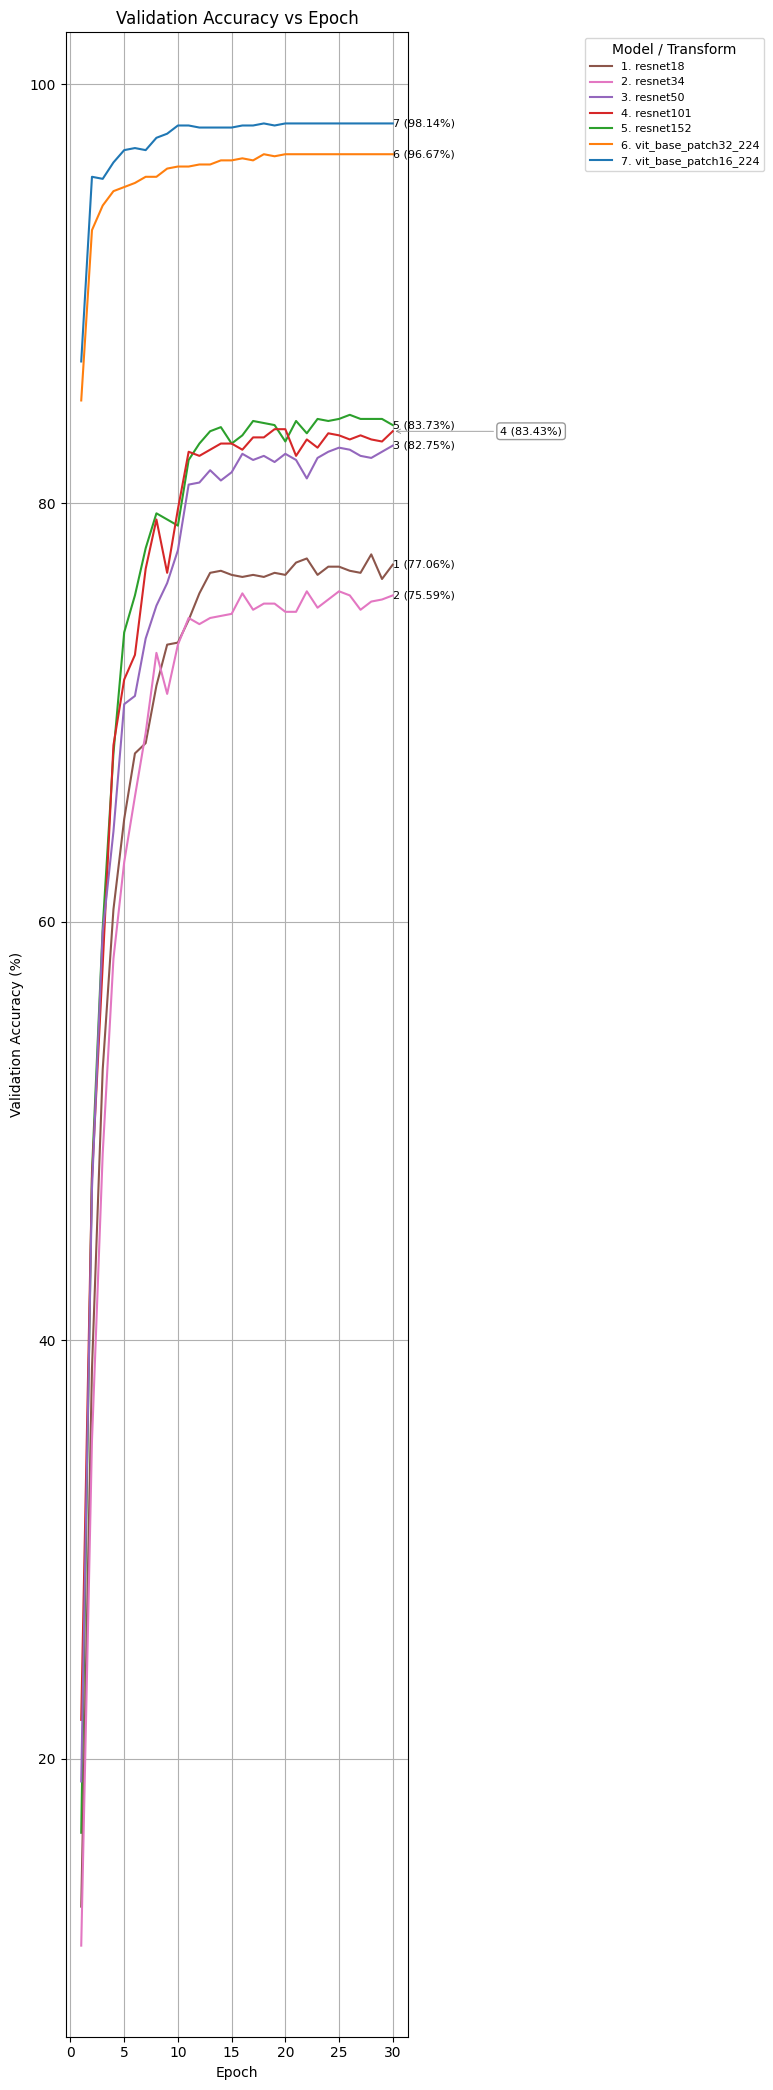

Saved: results/plots\basic\basic_test_accuracy_vs_model_size.png


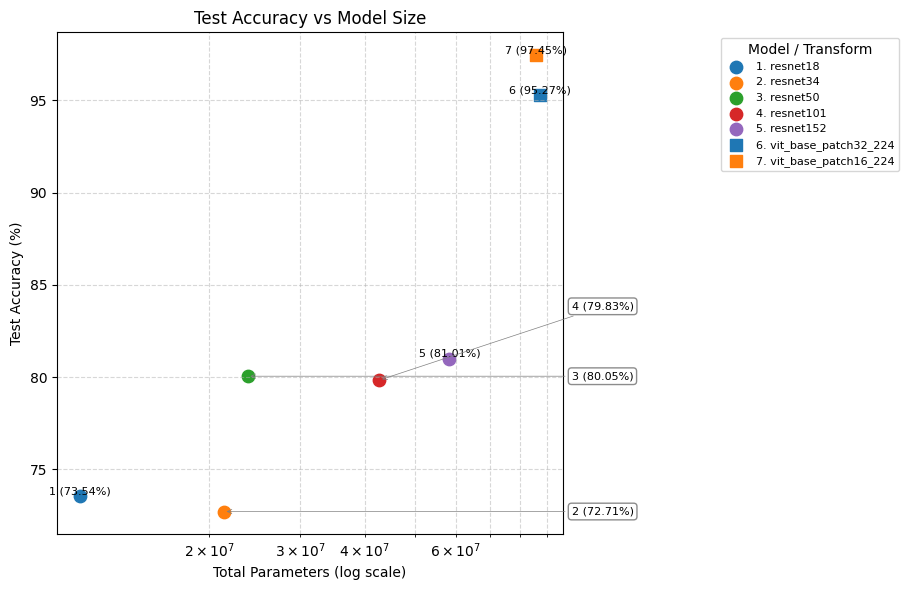

In [11]:
histories = get_or_compute_model_results(Mode.FULL_SKIP)
plot_model_histories(histories, "basic")

# 2. Reduce Parameters: Pruning

In [ ]:

class PruningUtils:
	@staticmethod
	def prune_conv_layer(conv: nn.Conv2d, amount: float, dim: int = 0):
		"""Return a pruned conv and the kept channel indices."""
		W = conv.weight.data
		num_channels = W.shape[dim]
		num_prune = int(num_channels * amount)
		norms = (W.view(num_channels, -1).norm(2, dim=1)
				if dim == 0 else
				W.permute(1, 0, 2, 3).contiguous().view(num_channels, -1).norm(2, dim=1))
		keep_idx = torch.argsort(norms, descending=True)[:num_channels - num_prune].sort()[0]

		new_conv = nn.Conv2d(
			in_channels=conv.in_channels if dim == 0 else len(keep_idx),
			out_channels=len(keep_idx) if dim == 0 else conv.out_channels,
			kernel_size=conv.kernel_size, # type: ignore
			stride=conv.stride, # type: ignore
			padding=conv.padding, # type: ignore
			dilation=conv.dilation, # type: ignore
			bias=conv.bias is not None,
			groups=conv.groups,
		)

		with torch.no_grad():
			if dim == 0:
				new_conv.weight = nn.Parameter(W[keep_idx].clone())
				if conv.bias is not None:
					new_conv.bias = nn.Parameter(conv.bias[keep_idx].clone())
			else:
				new_conv.weight = nn.Parameter(W[:, keep_idx].clone())
				if conv.bias is not None:
					new_conv.bias = nn.Parameter(conv.bias.clone())

		new_conv.to(device).requires_grad_(True)
		return new_conv, keep_idx

	@staticmethod
	def prune_linear_pair(fc1, fc2, amount: float):
		"""Prune hidden neurons in an MLP layer."""
		W1 = fc1.weight.data
		hidden_dim = W1.shape[0]
		num_prune = int(hidden_dim * amount)
		norms = W1.norm(2, dim=1)
		keep_idx = torch.argsort(norms, descending=True)[:hidden_dim - num_prune].sort()[0]

		new_fc1 = nn.Linear(fc1.in_features, len(keep_idx), bias=fc1.bias is not None)
		new_fc2 = nn.Linear(len(keep_idx), fc2.out_features, bias=fc2.bias is not None)

		with torch.no_grad():
			new_fc1.weight = nn.Parameter(W1[keep_idx].clone())
			if fc1.bias is not None:
				new_fc1.bias = nn.Parameter(fc1.bias[keep_idx].clone())
			new_fc2.weight = nn.Parameter(fc2.weight[:, keep_idx].clone())
			if fc2.bias is not None:
				new_fc2.bias = nn.Parameter(fc2.bias.clone())

		new_fc1.to(device).requires_grad_(True)
		new_fc2.to(device).requires_grad_(True)
		return new_fc1, new_fc2
	
	@staticmethod
	def rebuild_batchnorm(bn_old: nn.BatchNorm2d, new_num_features: int, keep_idx=None):
		"""Recreate a BatchNorm2d with correct num_features and copy surviving stats."""
		bn_new = nn.BatchNorm2d(new_num_features)

		if keep_idx is not None:
			with torch.no_grad():
				# Copy running stats if available
				if bn_old.running_mean is not None:
					bn_new.running_mean[:len(keep_idx)] = bn_old.running_mean[keep_idx].clone() # type: ignore
				if bn_old.running_var is not None:
					bn_new.running_var[:len(keep_idx)] = bn_old.running_var[keep_idx].clone() # type: ignore
				# Copy affine weights/bias if they exist
				if bn_old.affine:
					bn_new.weight.data[:len(keep_idx)] = bn_old.weight[keep_idx].clone()
					bn_new.bias.data[:len(keep_idx)] = bn_old.bias[keep_idx].clone()

		bn_new.to(device)
		return bn_new

In [13]:
class ResNetStructuredPruner:
	def __init__(self, amount: float):
		self.amount = amount

	def prune_basic_block(self, block):
		block.conv1, keep_idx = PruningUtils.prune_conv_layer(block.conv1, self.amount, dim=0)
		old_conv2 = block.conv2
		new_conv2 = nn.Conv2d(
			len(keep_idx), old_conv2.out_channels,
			old_conv2.kernel_size, old_conv2.stride,
			old_conv2.padding, bias=old_conv2.bias is not None)
		with torch.no_grad():
			new_conv2.weight = nn.Parameter(old_conv2.weight[:, keep_idx].clone())
			if old_conv2.bias is not None:
				new_conv2.bias = nn.Parameter(old_conv2.bias.clone())
		new_conv2.to(device).requires_grad_(True)
		block.conv2 = new_conv2
		block.bn1, block.bn2 = nn.BatchNorm2d(block.conv1.out_channels).to(device), nn.BatchNorm2d(block.conv2.out_channels).to(device)
		return block

	def prune_bottleneck_block(self, block):
		"""Prune a ResNet Bottleneck block safely."""
		# Prune conv2 output channels
		block.conv2, keep_idx = PruningUtils.prune_conv_layer(block.conv2, self.amount, dim=0)

		# Adjust conv3 input channels accordingly
		old_conv3 = block.conv3
		new_conv3 = nn.Conv2d(
			in_channels=len(keep_idx),
			out_channels=old_conv3.out_channels,
			kernel_size=old_conv3.kernel_size,
			stride=old_conv3.stride,
			padding=old_conv3.padding,
			bias=old_conv3.bias is not None
		)
		with torch.no_grad():
			new_conv3.weight = nn.Parameter(old_conv3.weight[:, keep_idx].clone())
			if old_conv3.bias is not None:
				new_conv3.bias = nn.Parameter(old_conv3.bias.clone())
		new_conv3.to(device)
		new_conv3.requires_grad_(True)
		block.conv3 = new_conv3

		# Rebuild BN layers with correct sizes
		block.bn2 = PruningUtils.rebuild_batchnorm(block.bn2, block.conv2.out_channels, keep_idx)
		block.bn3 = PruningUtils.rebuild_batchnorm(block.bn3, block.conv3.out_channels)

		# Move all to the same device
		ref_device = next(block.parameters()).device
		block.bn2.to(ref_device)
		block.bn3.to(ref_device)
		return block

	def prune_model(self, model):
		for lname in ['layer1', 'layer2', 'layer3', 'layer4']:
			layer = getattr(model, lname)
			for i, block in enumerate(layer):
				if hasattr(block, "conv3"):  # Bottleneck
					block = self.prune_bottleneck_block(block)
				else:
					block = self.prune_basic_block(block)
				layer[i] = block
		return model


class ViTStructuredPruner:
	def __init__(self, amount: float):
		self.amount = amount

	def prune_model(self, model):
		# Iterate directly over the transformer blocks
		for blk in model.blocks:
			# Each block has blk.mlp.fc1 and blk.mlp.fc2
			blk.mlp.fc1, blk.mlp.fc2 = PruningUtils.prune_linear_pair(
				blk.mlp.fc1, blk.mlp.fc2, self.amount
			)
		return model

In [14]:
class LocalUnstructuredPruner:
	def __init__(self, amount: float):
		self.amount = amount

	def apply(self, param_pairs):
		for module, name in param_pairs:
			prune.l1_unstructured(module, name=name, amount=self.amount)
	def finalise(self, param_pairs):
		for module, name in param_pairs:
			if hasattr(module, name + "_mask"):
				prune.remove(module, name)


class GlobalUnstructuredPruner:
	def __init__(self, amount: float):
		self.amount = amount

	def apply(self, param_pairs):
		prune.global_unstructured(param_pairs, pruning_method=prune.L1Unstructured, amount=self.amount)
	def finalise(self, param_pairs):
		for module, name in param_pairs:
			if hasattr(module, name + "_mask"):
				prune.remove(module, name)

In [15]:
class PruneTransform(ModelTransform):
	def __init__(self, name, structured, global_prune, amount=0.1, iterative_num_epochs=10, lr_restart_scaling=0.5):
		super().__init__(name)
		assert not(structured and global_prune), "Cannot use global structured pruning."
		self.structured = structured
		self.global_prune = global_prune
		self.amount = amount
		self.iterative_num_epochs = iterative_num_epochs
		self.lr_restart_scaling = lr_restart_scaling
		self.needs_finalise = True
		self.iterative = True
		# after pruning, want to only load model states that can fit in the current model. 
		if structured:
			self.purge_prev_model_state = True

	def __call__(self, model: nn.Module):
		for p in model.parameters(): p.requires_grad_(False)
		params_to_prune = []

		# === Structured pruning ===
		if self.structured:
			if isinstance(model, ResNet):
				model = ResNetStructuredPruner(self.amount).prune_model(model)
			elif isinstance(model, VisionTransformer):
				model = ViTStructuredPruner(self.amount).prune_model(model)
			else:
				raise NotImplementedError(f"model {model.__class__.__name__} not implemented")
			
		# === Unstructured pruning ===
		else:
			if isinstance(model, ResNet):
				# Only prune conv weights inside BasicBlock or Bottleneck blocks
				for m in model.modules():
					if isinstance(m, (BasicBlock, Bottleneck)):
						for sub in m.modules():
							if isinstance(sub, nn.Conv2d):
								sub.requires_grad_(True)
								params_to_prune.append((sub, "weight"))

			elif isinstance(model, VisionTransformer):
				# Only prune MLP linear weights (fc1 and fc2 inside blk.mlp)
				# getattr(model, "blocks", []) returns nn.Sequential which is iterable
				for blk in getattr(model, "blocks", []):
					if hasattr(blk, "mlp"):
						for _name, sub in blk.mlp.named_modules():
							if isinstance(sub, nn.Linear):
								sub.requires_grad_(True)
								params_to_prune.append((sub, "weight"))

			else:
				raise NotImplementedError(f"Unstructured pruning not defined for {model.__class__.__name__}")

			# Apply pruning
			if self.global_prune:
				GlobalUnstructuredPruner(self.amount).apply(params_to_prune)
			else:
				LocalUnstructuredPruner(self.amount).apply(params_to_prune)

		return model
	
	def finalise(self, model: nn.Module) -> nn.Module:
		"""Remove pruning reparameterizations and restore model parameters."""
		params_to_prune = []

		if not self.structured:
			if isinstance(model, ResNet):
				for m in model.modules():
					if isinstance(m, (BasicBlock, Bottleneck)):
						for sub in m.modules():
							if isinstance(sub, nn.Conv2d):
								params_to_prune.append((sub, "weight"))

			elif isinstance(model, VisionTransformer):
				for blk in getattr(model, "blocks", []):
					if hasattr(blk, "mlp"):
						for _name, sub in blk.mlp.named_modules():
							if isinstance(sub, nn.Linear):
								params_to_prune.append((sub, "weight"))

			if self.global_prune:
				GlobalUnstructuredPruner(self.amount).finalise(params_to_prune)
			else:
				LocalUnstructuredPruner(self.amount).finalise(params_to_prune)

		# Freeze all gradients
		for p in model.parameters():
			p.requires_grad_(False)

		return model


Found existing results for 'resnet18_structured_local_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34_structured_local_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'resnet50_structured_local_pruning', loading metrics...
Found existing results for 'resnet50_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet50_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet50', loading metrics...
Found existing results for 'resnet101_structured_local_pruning',

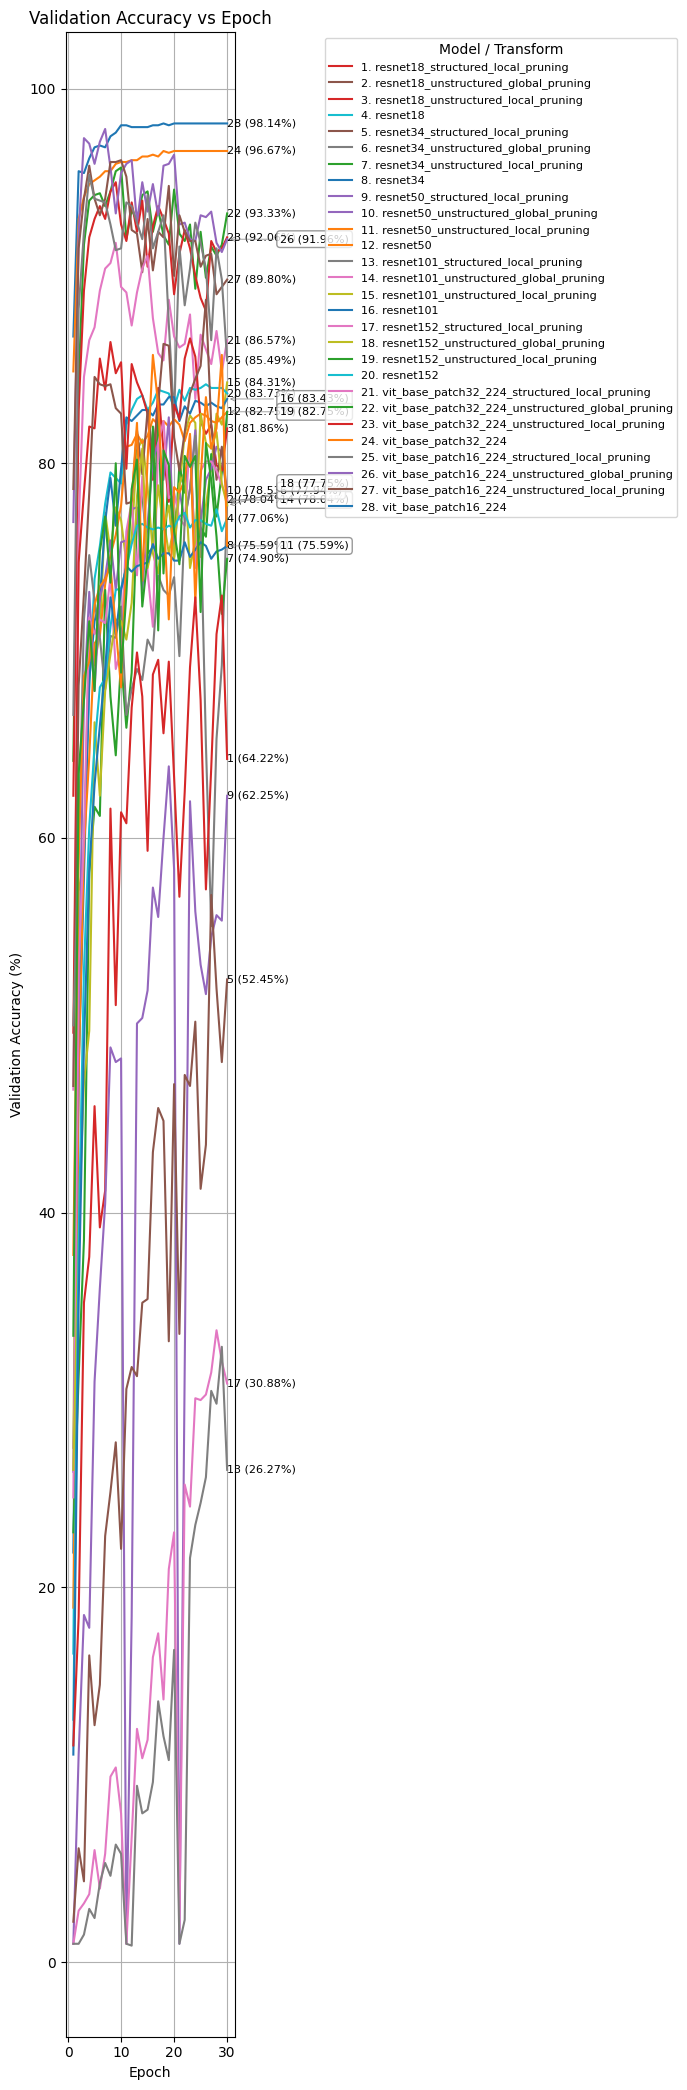

Saved: results/plots\pruning\pruning_test_accuracy_vs_model_size.png


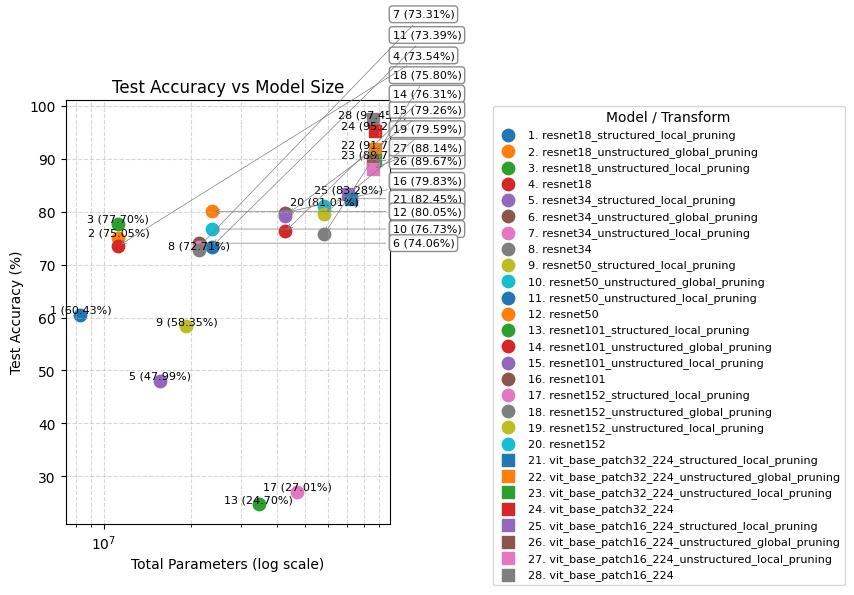

In [16]:
structured_local_pruning = PruneTransform(name="structured_local_pruning", structured=True, global_prune=False)
unstructured_global_pruning = PruneTransform(name="unstructured_global_pruning", structured=False, global_prune=True)
unstructured_local_pruning =PruneTransform(name="unstructured_local_pruning", structured=False, global_prune=False)

histories = get_or_compute_model_results(
	mode=Mode.FULL_SKIP,
	model_transforms=[structured_local_pruning, unstructured_global_pruning, unstructured_local_pruning],
)
plot_model_histories(histories, "pruning")

# 3. ResNet Improvements: Deformable Convolutions

In [17]:
# Prof we can provide our original implementation if you're interested, we decided to switch to open source libraries as it took 15 minutes and to finish training 1 epoch due to open source libraries better integrated with cuda 

class DeformableConv2d(nn.Module):
	def __init__(self, conv: nn.Conv2d, device):
		super().__init__()
		self.in_channels = conv.in_channels
		self.out_channels = conv.out_channels
		self.kernel_size = conv.kernel_size[0]
		self.stride = conv.stride
		self.padding = conv.padding
		self.dilation = conv.dilation
		self.groups = conv.groups
		self.bias = conv.bias is not None

		# Learnable offsets (2*k*k channels)
		self.offset_conv = nn.Conv2d(
			self.in_channels,
			2 * self.kernel_size * self.kernel_size,
			kernel_size=self.kernel_size,
			stride=self.stride, # type: ignore
			padding=self.padding # type: ignore
		)

		# Actual deformable convolution
		self.deform_conv = DeformConv2d(
			self.in_channels,
			self.out_channels,
			kernel_size=self.kernel_size,
			stride=self.stride,
			padding=self.padding, # type: ignore
			dilation=self.dilation,
			groups=self.groups,
			bias=self.bias
		)

		# Copy original weights
		self.deform_conv.weight.data.copy_(conv.weight.data)
		if self.bias:
			self.deform_conv.bias.data.copy_(conv.bias.data) # type: ignore

		self.to(device)

	def forward(self, x):
		offset = self.offset_conv(x)
		return self.deform_conv(x, offset)


class DeformableConvTransform(ModelTransform):
	def __init__(self, name: str = "deformable_convolutions_transform", device: str| torch.device = device):
		if name != "deformable_convolutions_transform":
			print(f"name set to {name}. Note previous saved model weights and model results are saved under deformable_convolutions_transform instead. This will break loading those models.")
		super().__init__(name)
		self.device = device

	def __call__(self, model: nn.Module) -> nn.Module:
		if not isinstance(model, ResNet):
			raise NotImplementedError(f"[{self.name}] Model type {model.__class__} not supported.")

		for module_name, module in model.named_modules():
			if isinstance(module, nn.Conv2d):
				# Skip 1×1 convolutions (likely downsampling or pointwise)
				if module.kernel_size == (1, 1):
					continue

				# Skip first convolutional layer, preserve some information for later layers to work on 
				if module_name == "conv1":
					continue

				# Find parent module
				parent = model
				*path, last = module_name.split(".")
				if not any(x.startswith("layer") for x in path):
					continue
				for p in path:
					parent = getattr(parent, p)

				# Replace with deformable convolution
				setattr(parent, last, DeformableConv2d(module, device=self.device))
				module.requires_grad_(True)


		return model
	
	def applies_to(self, model_name: str) -> bool:
		if "vit" in model_name:
			return False
		elif "resnet" in model_name:
			return True
		else:
			return False

	def applies_to_class(self, model: nn.Module) -> bool:
		if isinstance(model, VisionTransformer):
			return False
		elif isinstance(model, ResNet):
			return True
		else:
			return False

In [18]:
def visualize_all_deformable_offsets(model_name="resnet18", input_image=None, device=device):

	deform_conv = DeformableConvTransform()
	if not deform_conv.applies_to(model_name):
		raise NotImplementedError(f"deformable convolutions are not defined for {model_name}")

	if input_image is None:
		input_image = next(iter(test_loader))[0][0:1]  # shape (1, C, H, W)
	input_image = input_image.to(device)

	# --- load model ---
	model = timm.create_model(model_name, pretrained=False, num_classes=102)
	model = deform_conv(model)
	model.to(device)
	model.eval()

	# --- load weights if exist ---
	transformed_model_name = f"{model_name}_deformable_convolutions_transform"
	weights_path = os.path.join("results", "model_weights", transformed_model_name, f"{transformed_model_name}_best.pth")
	if os.path.exists(weights_path):
		state_dict = torch.load(weights_path, map_location=device)
		model.load_state_dict(state_dict, strict=False)

	# --- get deformable layers ---
	deform_layers = [(name, m) for name, m in model.named_modules() if isinstance(m, DeformableConv2d)]
	if not deform_layers:
		raise RuntimeError("No DeformableConv2d layers found!")

	print(f"Found {len(deform_layers)} deformable layers")

	# --- set up hooks to capture inputs ---
	features = {}

	def get_hook(name):
		def hook(module, input, output):
			features[name] = input[0].detach()
		return hook

	hooks = [m.register_forward_hook(get_hook(name)) for name, m in deform_layers]

	# --- forward pass once to capture features ---
	with torch.no_grad():
		_ = model(input_image)
	# --- visualize each offset map ---
	n_layers = len(deform_layers)
	n_cols = 5
	n_rows = (n_layers + n_cols - 1) // n_cols

	plt.figure(figsize=(4 * n_cols, 4 * n_rows))

	for i, (layer_name, deform_layer) in enumerate(deform_layers, 1):
		if layer_name not in features:
			print(f"Layer {layer_name} not in features, skipping.")
			continue
			
		deform_layer.eval()
		with torch.no_grad():
			# Use the actual feature map captured by the hook
			feature_input = features[layer_name]
			
			if hasattr(deform_layer, 'offset_conv'):
				offset = deform_layer.offset_conv(feature_input)
			else:
				print(f"Layer {layer_name} missing offset_conv, skipping.")
				continue

		offset_np = offset.cpu().numpy()[0]
		H, W = offset_np.shape[1:]
		
		# Average across all offset pairs (x and y)
		offset_x = offset_np[::2].mean(axis=0)
		offset_y = offset_np[1::2].mean(axis=0)
		
		# Create sampling grid - adaptive based on size
		# Use more samples for smaller feature maps
		max_arrows = 20
		step = max(1, max(H, W) // max_arrows)
		
		y_coords = np.arange(0, H, step)
		x_coords = np.arange(0, W, step)
		X, Y = np.meshgrid(x_coords, y_coords)
		
		# Sample offsets at grid points using proper indexing
		offset_x_sampled = offset_x[y_coords[:, None], x_coords]
		offset_y_sampled = offset_y[y_coords[:, None], x_coords]

		plt.subplot(n_rows, n_cols, i)
		
		# Show the feature map as background
		feature_vis = feature_input[0].mean(0).cpu().numpy()
		plt.imshow(feature_vis, cmap='gray', alpha=0.5, extent=[0, W, H, 0]) # type: ignore
		
		# Compute magnitude for color scaling
		magnitude = np.sqrt(offset_x_sampled**2 + offset_y_sampled**2)
		
		# Adaptive scaling based on feature map size and offset statistics
		offset_scale = np.percentile(magnitude, 95) if magnitude.max() > 0 else 1.0
		scale_factor = max(H, W) / (20 * max(offset_scale, 0.1))
		
		# Plot arrows with proper coordinates
		plt.quiver(X, Y, offset_x_sampled, offset_y_sampled, 
				magnitude, 
				angles='xy', 
				scale_units='xy', 
				scale=scale_factor,
				cmap='hot',
				alpha=0.8,
				width=0.003,
				headwidth=3,
				headlength=4)
		
		plt.xlim(0, W)
		plt.ylim(H, 0)  # Inverted y-axis to match image coordinates
		plt.title(f"{layer_name}\n{H}x{W}, scale={scale_factor:.2f}", fontsize=8)
		plt.axis('off')

	plt.tight_layout()
	plt.show()

	# cleanup hooks
	for h in hooks:
		h.remove()

Found existing results for 'resnet18_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'resnet50_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet50', loading metrics...
Found existing results for 'resnet101_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet101', loading metrics...
Found existing results for 'resnet152_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet152', loading metrics...
Found existing results for 'vit_base_patch32_224', loading metrics...
Found existing results for 'vit_base_patch16_224', loading metrics...
All histories saved to results/all_histories.json
Saved: results/plots\deformable_conv\deformable_conv_val

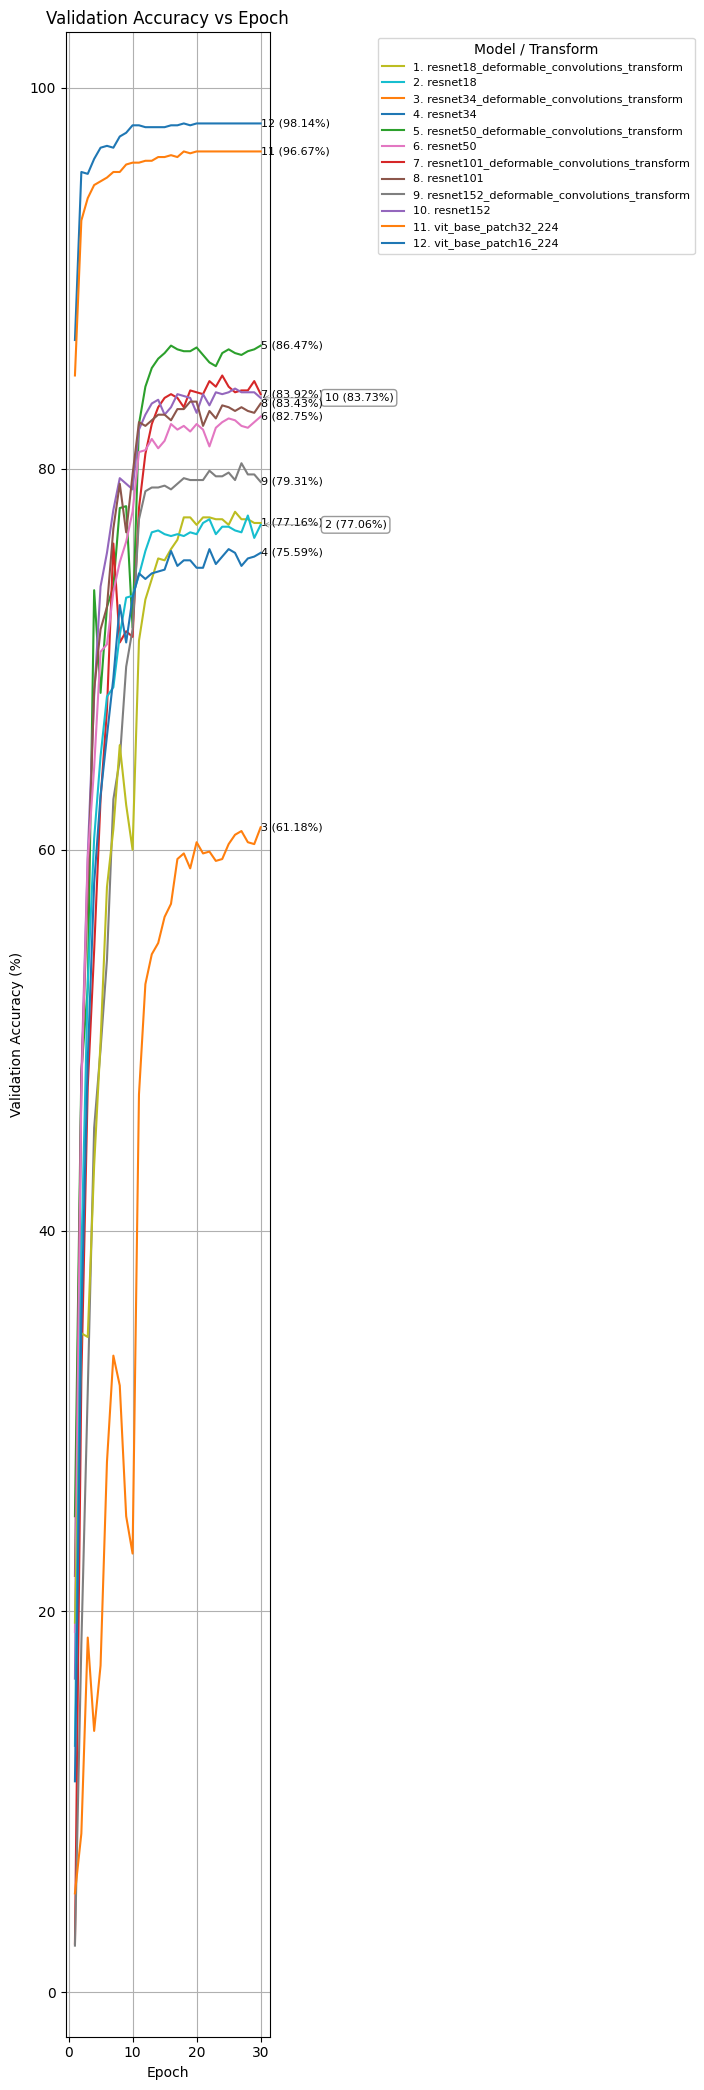

Saved: results/plots\deformable_conv\deformable_conv_test_accuracy_vs_model_size.png


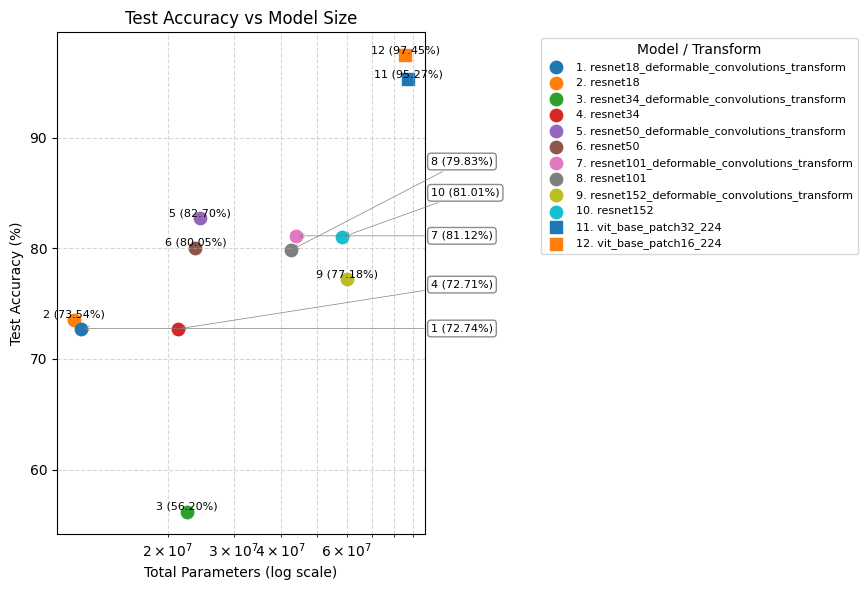

In [19]:
deformable_transform = DeformableConvTransform()
histories = get_or_compute_model_results(model_transforms=(deformable_transform,) 
										, mode=Mode.FULL_SKIP, )
plot_model_histories(histories, "deformable_conv") 

Found 16 deformable layers


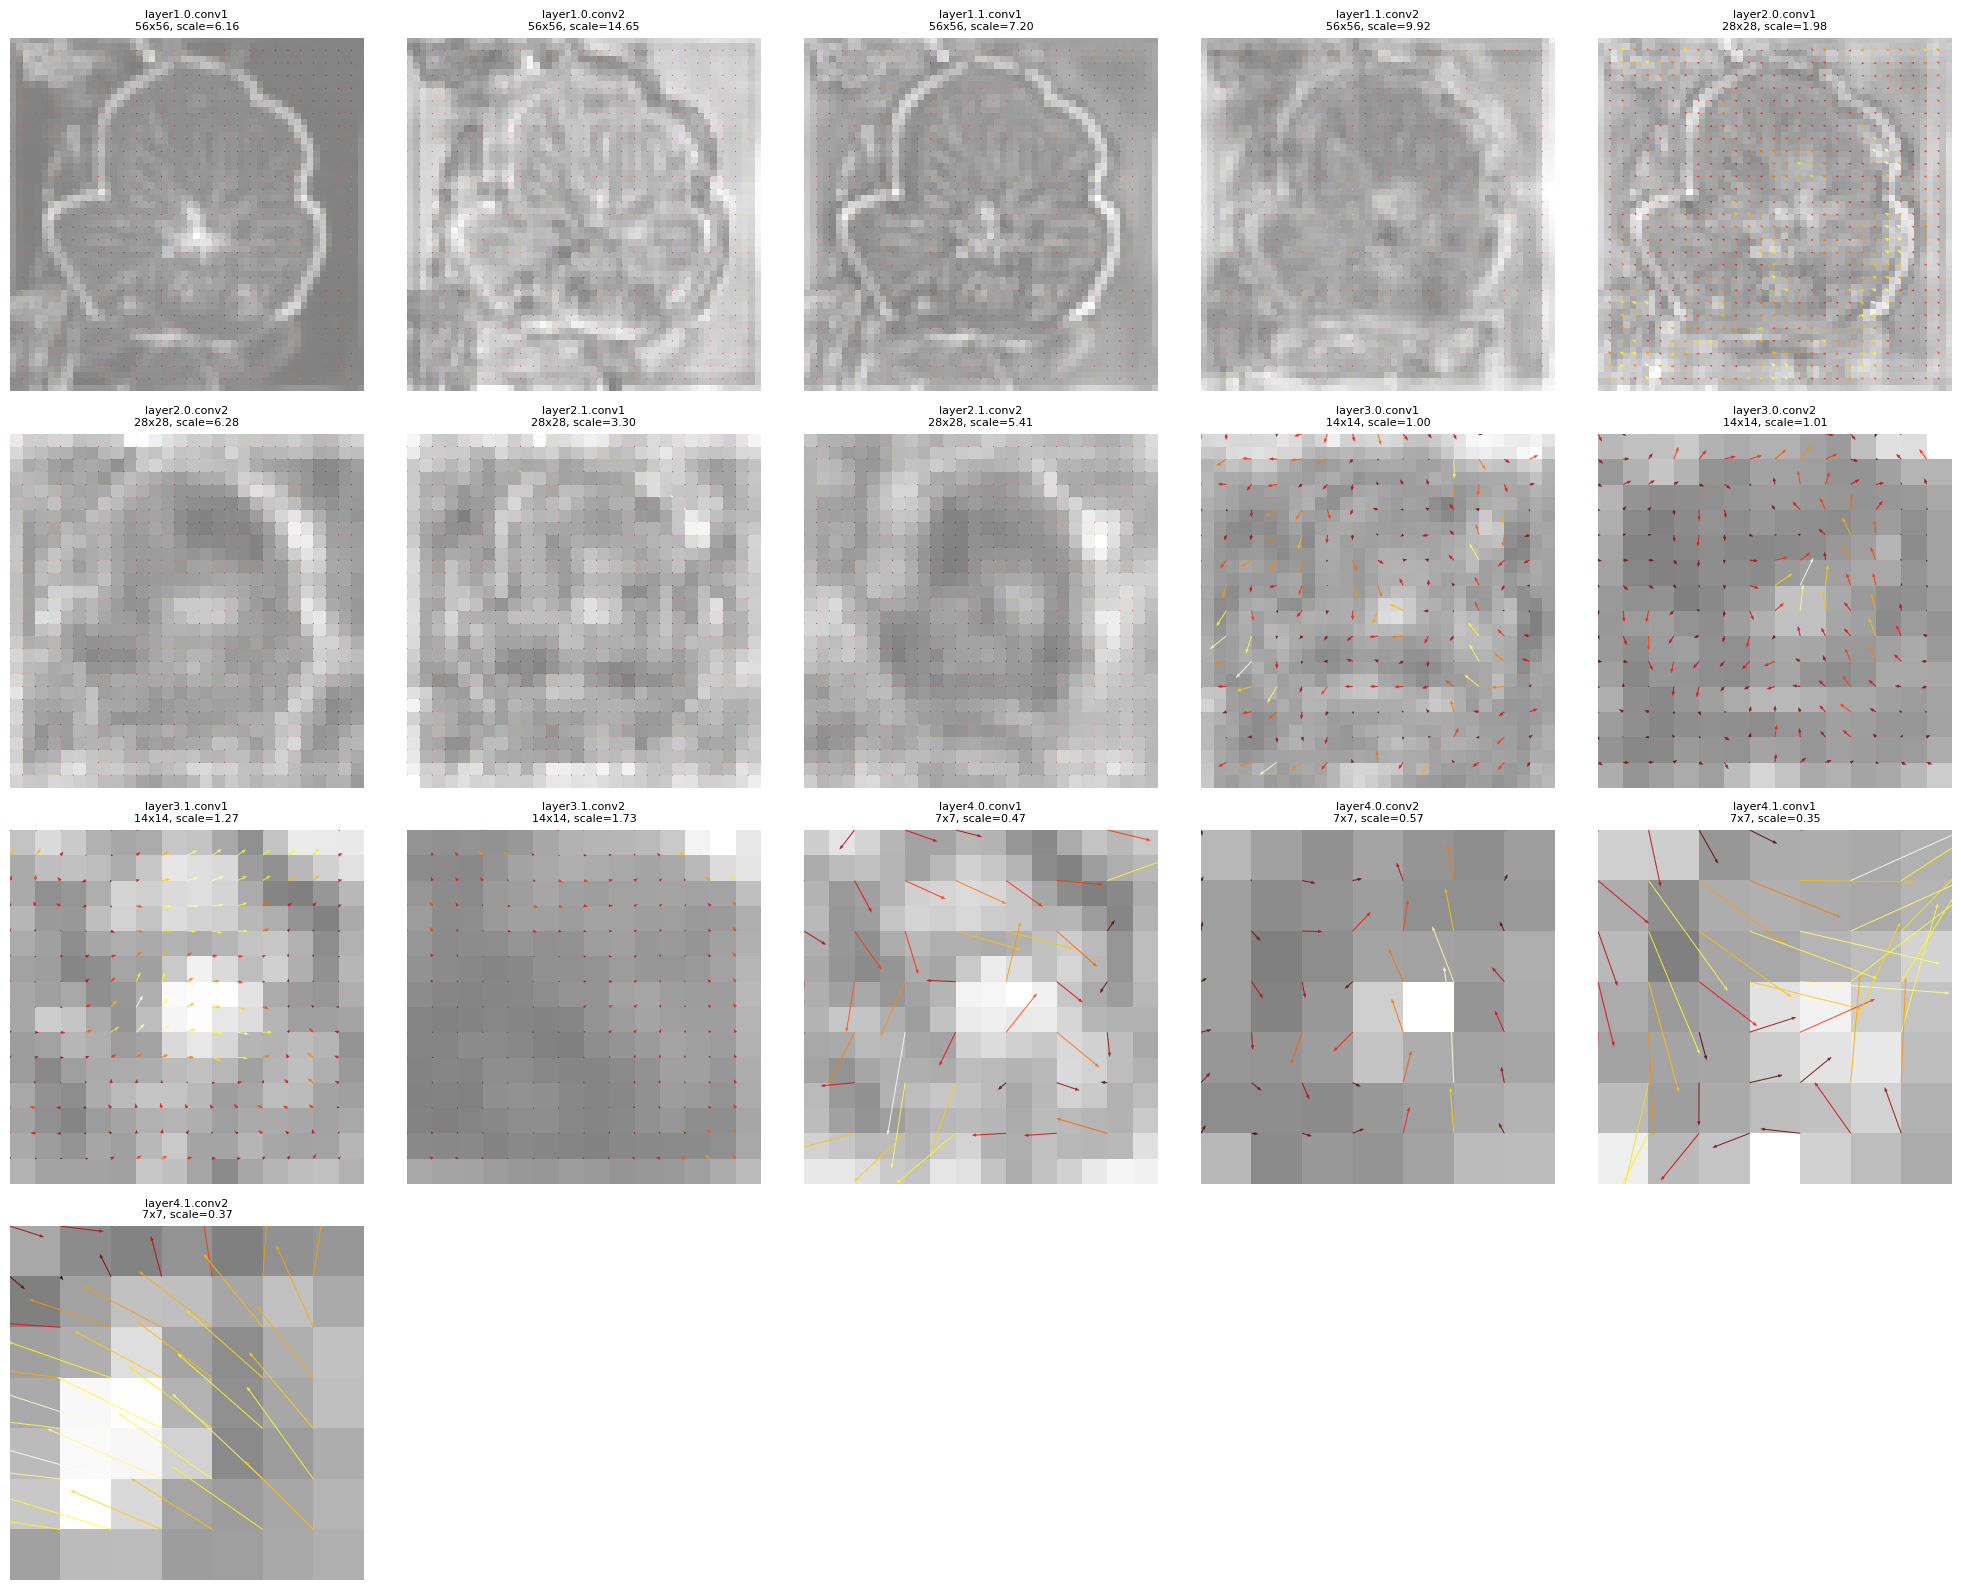

In [20]:
visualize_all_deformable_offsets("resnet18")

# 4. ViT Improvements: Visual Prompt Tuning

In [21]:
class VisualPromptedVisionTransformer(nn.Module):
	def __init__(self, vit: VisionTransformer, num_prompt_tokens: int = 10, 
				prompt_pos: bool = True, train_head: bool = True, freeze_backbone: bool = True):
		"""
		Wrap a torchvision VisionTransformer to add visual prompt tokens.

		Args:
			vit: an instance of torchvision.models.vision_transformer.VisionTransformer
			num_prompt_tokens: number of prompt tokens (k)
			prompt_pos: whether to use a small learnable positional embedding for prompt tokens
			train_head: if True, keep the classification head trainable; otherwise freeze it too
			freeze_backbone: if True, freeze all vit parameters except prompt tokens (and head if train_head)
		"""
		super().__init__()
		if not isinstance(vit, VisionTransformer):
			raise NotImplementedError("VisualPromptedVisionTransformer currently only supports torchvision VisionTransformer.")
		self.vit = vit
		self.k = int(num_prompt_tokens)

		# infer embedding dimension
		embed_dim = getattr(vit, "embed_dim", None)
		if embed_dim is None:
			raise RuntimeError("Could not infer ViT embedding dimension. Please check model attributes.")

		# prompt token parameters: shape (1, k, embed_dim) for easy broadcasting
		self.prompt_tokens = nn.Parameter(torch.randn(1, self.k, embed_dim) * 0.02).to(device)

		# positional embeddings for prompts (shape matches pos_embed's embedding dim)
		self.use_prompt_pos = bool(prompt_pos)
		if self.use_prompt_pos:
			self.prompt_pos_embed = nn.Parameter(torch.zeros(1, self.k, embed_dim)).to(device)
		else:
			self.prompt_pos_embed = None

		# whether to keep head trainable
		self.train_head = bool(train_head)

		# freeze backbone if requested
		if freeze_backbone:
			for _name, p in self.vit.named_parameters():
				p.requires_grad = False

			# allow classifier head to be trainable if requested
			if self.train_head:
				# common names: head, fc, classifier
				if hasattr(self.vit, "head"):
					for p in self.vit.head.parameters():
						p.requires_grad = True
				elif hasattr(self.vit, "fc"):
					for p in self.vit.fc.parameters():
						p.requires_grad = True
				elif hasattr(self.vit, "classifier"):
					for p in self.vit.classifier.parameters():
						p.requires_grad = True

		self.device = device

	def forward(self, x):
		# Follow the general torchvision ViT forward: patch_embed -> add cls token & pos_embed -> blocks -> norm -> head
		# But inject prompt tokens after cls token and before patches

		# 1) get patch embeddings (B, num_patches, embed_dim)
		# torchvision VisionTransformer has patch_embed(...) which returns flattened patch embeddings
		patches = self.vit.patch_embed(x)  # typically (B, N, C) or (B, C, num_patches) depending on impl

		# torchvision's PatchEmbed often returns shape (B, num_patches, embed_dim).
		# If patch_embed returns (B, C, H, W) need to flatten; assume standard behavior.
		# If it's (B, C, H, W) then convert:
		if patches.ndim == 4:
			# fallback: flatten
			B = patches.shape[0]
			patches = patches.flatten(2).transpose(1, 2)

		B, N, C = patches.shape  # batch, num_patches, embed_dim

		# 2) prepare cls token (if present)
		cls_token = getattr(self.vit, "cls_token", None)
		if cls_token is None:
			# some implementations use 'class_token' or similar
			cls_token = getattr(self.vit, "class_token", None)
		if cls_token is None:
			# if still None, create a temporary zero token (not ideal but fallback)
			cls = torch.zeros(B, 1, C, device=patches.device, dtype=patches.dtype)
		else:
			# cls_token is registered param of shape (1, 1, C)
			cls = cls_token.expand(B, -1, -1)

		# 3) prompt tokens: expand to batch
		prompt_tokens = self.prompt_tokens.expand(B, -1, -1)  # (B, k, C)
		if self.use_prompt_pos and (self.prompt_pos_embed is not None):
			prompt_pos = self.prompt_pos_embed.expand(B, -1, -1)
		else:
			prompt_pos = None

		# 4) position embeddings from original model
		# torchvision ViT often has 'pos_embed' of shape (1, 1+N, C)
		pos_embed = getattr(self.vit, "pos_embed", None)
		if pos_embed is None:
			# some variants call it 'pos_embedding'
			pos_embed = getattr(self.vit, "pos_embedding", None)

		# Build sequence: [CLS], prompt_tokens, patches -> add pos embeddings appropriately
		# Sequence without pos: seq = torch.cat([cls, prompt_tokens, patches], dim=1)

		seq = torch.cat([cls, prompt_tokens, patches], dim=1)  # (B, 1 + k + N, C)

		# Add positional embeddings:
		if pos_embed is not None:
			# pos_embed shape usually (1, 1+N, C)
			# construct a new pos embed for the extended length by concatenating prompt_pos (or zeros) with existing pos_embed
			orig_pos = pos_embed
			# if orig_pos length doesn't match patches, try to interpolate/resample (skip for simplicity)
			# simplest: concatenate prompt_pos (zeros or param) in front of orig_pos
			if prompt_pos is not None:
				# prompt_pos is (B, k, C), but positional embeddings are not batch dependent. Use the single param version:
				prompt_pos_param = self.prompt_pos_embed  # shape (1, k, C)
			else:
				# zeros
				prompt_pos_param = torch.zeros(1, self.k, C, device=seq.device, dtype=seq.dtype)

			# Now final_pos_embed: (1, 1 + k + N, C)
			# orig_pos may already include cls position; keep it as-is after concatenating prompt positions in front of it
			final_pos = torch.cat([orig_pos[:, :1, :], prompt_pos_param, orig_pos[:, 1:, :]], dim=1) # type: ignore
			
			# final_pos shape should match seq length; if not, try to expand/interpolate
			if final_pos.shape[1] != seq.shape[1]:
				# fallback: resize via interpolation on the patch portion (naive) - preserve cls+prompt if possible
				# Try to interpolate the positional embeddings of patches only.
				# orig_pos: (1, 1+N0, C) where N0 might equal N; if N doesn't match we'll do linear interpolation on patch positions
				# For simplicity: if lengths mismatch, just create zeros pos for prompts + orig_pos repeated/truncated
				final_pos = torch.zeros(1, seq.shape[1], C, device=seq.device, dtype=seq.dtype)
				# place cls pos and then fill the rest approximately
				final_pos[:, :orig_pos.shape[1], :] = orig_pos
				# else leave remaining zeros. (This is conservative fallback.)
			seq = seq + final_pos.to(seq.dtype).to(seq.device)
		else:
			# no pos embedding available in model -> skip adding pos embeddings
			pass

		# 5) pass through dropout / pre-norm if the model has them
		# torchvision ViT has pos_drop
		if hasattr(self.vit, "pos_drop"):
			seq = self.vit.pos_drop(seq)
		elif hasattr(self.vit, "dropout"):
			seq = self.vit.dropout(seq)

		# 6) transformer encoder blocks
		# torchvision sequences: sometimes model has 'norm_pre' before blocks
		if hasattr(self.vit, "norm_pre") and self.vit.norm_pre is not None:
			seq = self.vit.norm_pre(seq)

		# some implementations expect transpose/reshaping; assume blocks accept (B, S, C)
		for blk in self.vit.blocks:
			seq = blk(seq)

		# 7) final norm then head
		if hasattr(self.vit, "norm") and self.vit.norm is not None:
			seq = self.vit.norm(seq)
		elif hasattr(self.vit, "pre_logits") and self.vit.pre_logits is not None:
			seq = self.vit.pre_logits(seq)

		# read out CLS token which is first token
		cls_out = seq[:, 0]

		# classifier head - try common names
		if hasattr(self.vit, "head") and self.vit.head is not None:
			logits = self.vit.head(cls_out)
		elif hasattr(self.vit, "fc") and self.vit.fc is not None:
			logits = self.vit.fc(cls_out)
		elif hasattr(self.vit, "classifier") and self.vit.classifier is not None:
			logits = self.vit.classifier(cls_out)
		else:
			# fallback: no head found, return CLS vector
			logits = cls_out

		return logits

class visual_prompt_tuning_transform(ModelTransform): 
	def __init__(self, name: str = "visual_prompt_tuning_transform", num_prompt_tokens: int = 10, prompt_pos: bool = True, train_head: bool = True, freeze_backbone: bool = True): 
		if name != "visual_prompt_tuning_transform": 
			print(f"name set to {name}. Note previous saved model weights and model results are saved under deformable_convolutions_transform instead. This will break loading those models.") 
		super().__init__(name) 
		self.num_prompt_tokens = num_prompt_tokens
		self.prompt_pos = prompt_pos
		self.train_head = train_head
		self.freeze_backbone = freeze_backbone

	def __call__(self, model: nn.Module) -> nn.Module: 
		if not isinstance(model, VisionTransformer): 
			raise NotImplementedError(f"[{self.name}] Model type {model.__class__} not supported.")
		wrapped = VisualPromptedVisionTransformer(model, num_prompt_tokens=self.num_prompt_tokens,
											prompt_pos=self.prompt_pos, train_head=self.train_head,
											freeze_backbone=self.freeze_backbone)
		return wrapped
	
	def applies_to(self, model_name: str) -> bool:
		if "vit" in model_name:
			return True
		elif "resnet" in model_name:
			return False
		else:
			return False

Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'resnet50', loading metrics...
Found existing results for 'resnet101', loading metrics...
Found existing results for 'resnet152', loading metrics...
Found existing results for 'vit_base_patch32_224_visual_prompt_tuning_transform', loading metrics...
Found existing results for 'vit_base_patch32_224', loading metrics...
Found existing results for 'vit_base_patch16_224_visual_prompt_tuning_transform', loading metrics...
Found existing results for 'vit_base_patch16_224', loading metrics...
All histories saved to results/all_histories.json
Saved: results/plots\visual_prompt_tuning\visual_prompt_tuning_validation_accuracy_vs_epoch.png


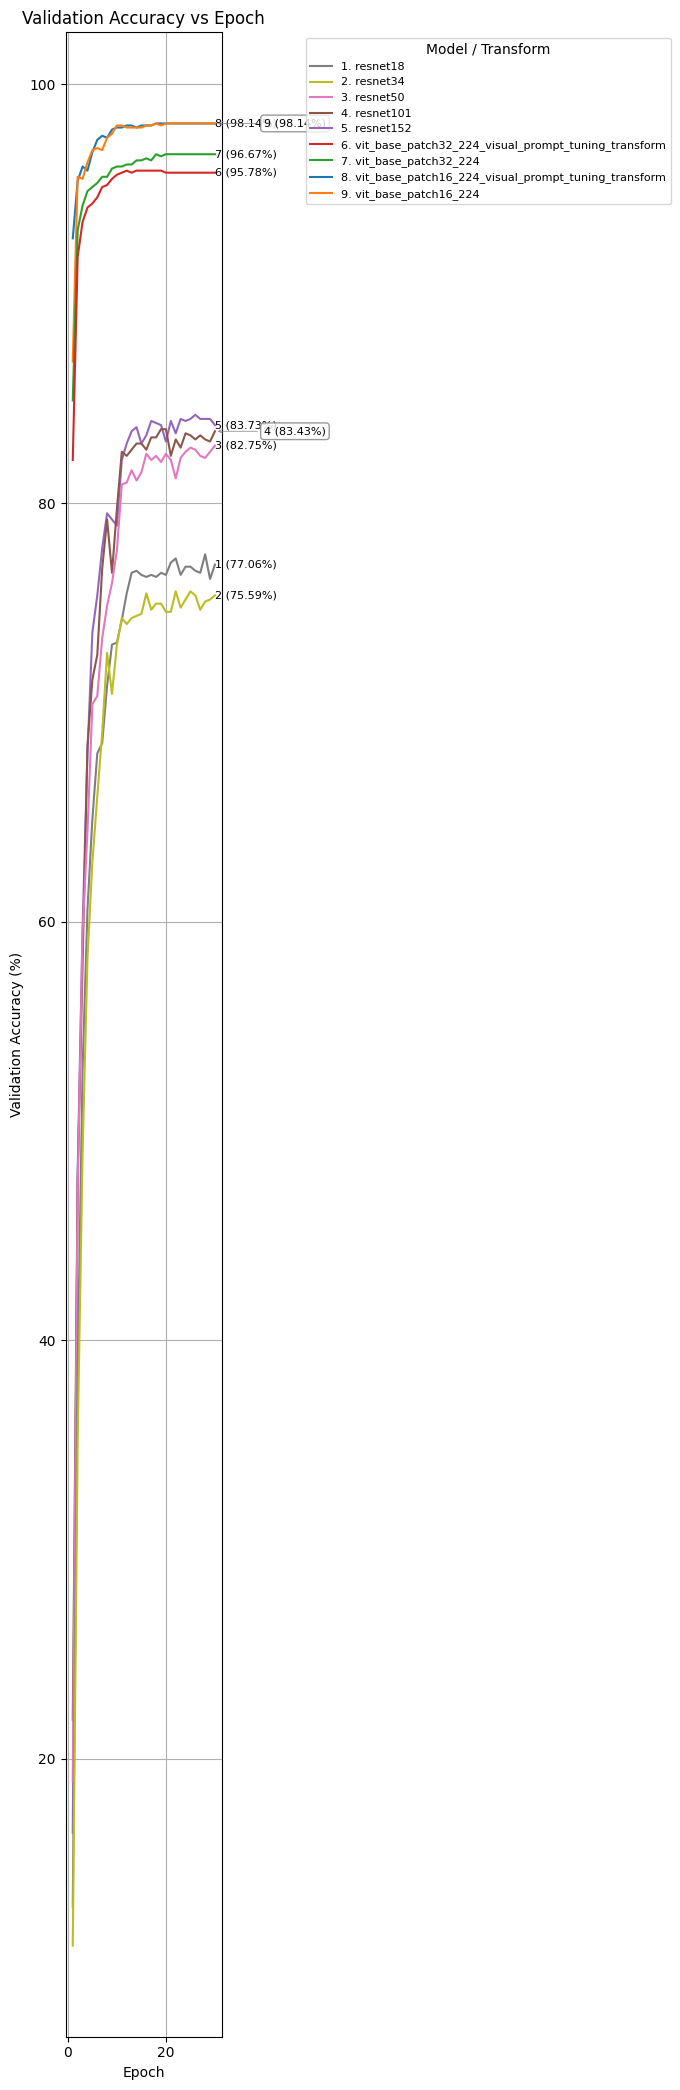

Saved: results/plots\visual_prompt_tuning\visual_prompt_tuning_test_accuracy_vs_model_size.png


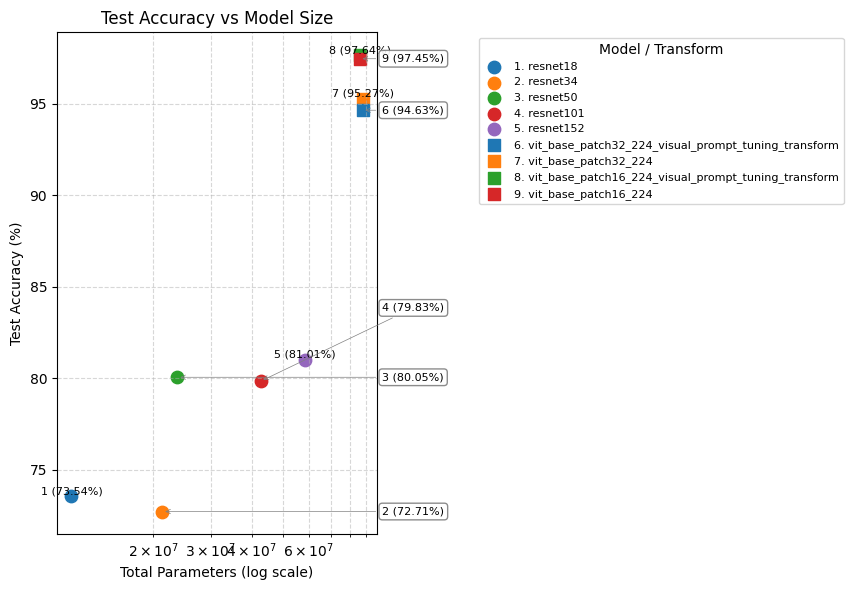

In [22]:
histories = get_or_compute_model_results(model_transforms=(visual_prompt_tuning_transform(),)
										, mode=Mode.FULL_SKIP)
plot_model_histories(histories, "visual_prompt_tuning")

# Overall diagram

Found existing results for 'resnet18_structured_local_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet18_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34_structured_local_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet34_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'resnet50_structured_local_pruning', loading metrics...
Found existing results for 'resnet50_unstructured_global_pruning', loading metrics...
Found existing results 

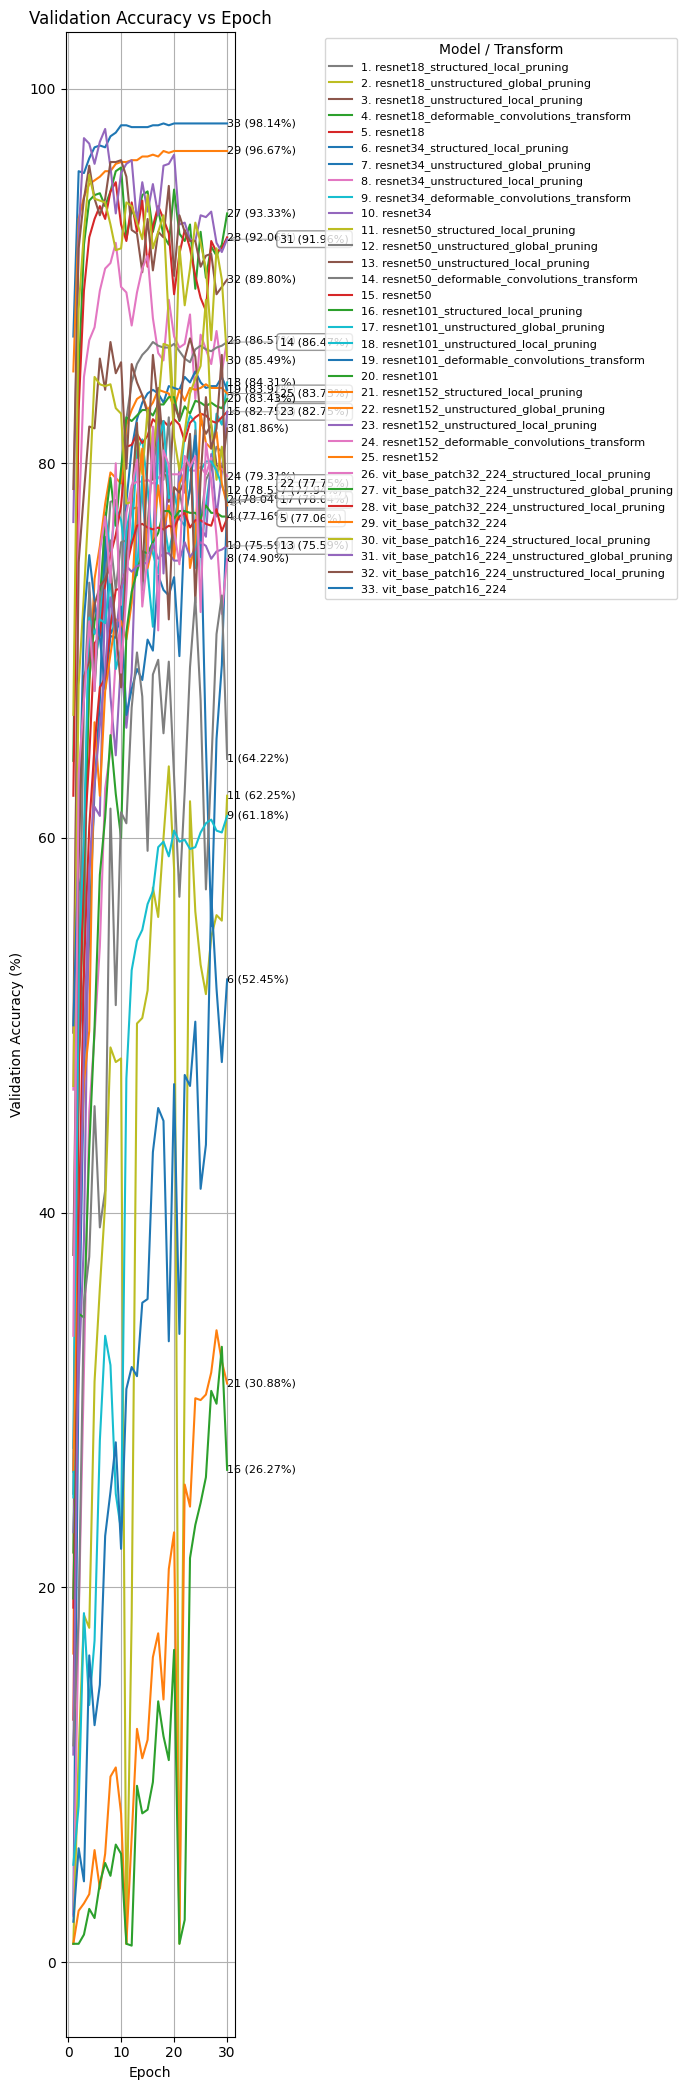

Saved: results/plots\overall\overall_test_accuracy_vs_model_size.png


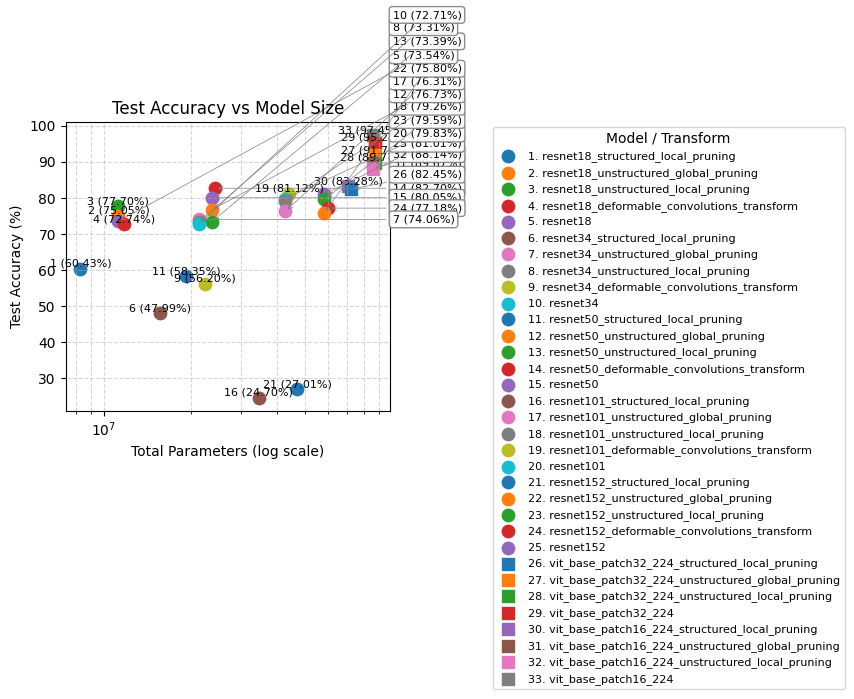

In [23]:
histories = get_or_compute_model_results(model_transforms=(structured_local_pruning, unstructured_global_pruning, unstructured_local_pruning, deformable_transform,)
										, mode=Mode.FULL_SKIP)
plot_model_histories(histories, "overall")